# Utilização do Modelo de Support Vector Machines (SVM) na Análise de Crédito
#### Tutorial por: Victor Dahan
- Linkedin: https://www.linkedin.com/in/victordhn/

**Objetivo:** Este tutorial demonstrará como utilizar modelos de machine learning para prever o risco de crédito. O objetivo é maximizar a precisão do modelo, mantendo ao mesmo tempo a capacidade de generalizar os resultados para outros conjuntos de dados de operações de crédito.

**Modelo Utilizados:** Como este é um desafio de classificação, utilizaremos diversos modelos classificatórios nessa série. Começaremos com o Support Vector Machine (SVM), método que utiliza o mecanismo de formação de hiperplanos para a previsão de variáveis binárias.
___

#### 1. Breve introdução modelo Support Vector Machine (SVM)

- O Support Vector Machine é um modelo de Machine Learning utilizado para problemas de classificação e é eficaz em encontrar a melhor fronteira (ou hiperplano) que separa diferentes classes de dados no espaço das variáveis. 
- Os hiperparâmetros utilizados no modelo são o kernel (sendo os mais comuns o radial (RBF), linear e polinomial), o parâmetro de regularização utilizando para controlar o erro de classificação (chamado de 'c' no modelo) e o parâmetro de controle de influência de cada observação (utilizado no kernel RBF e chamado de 'gamma')

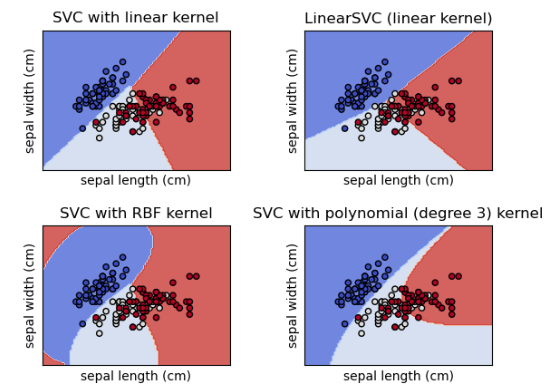

##### Importando o dataset 
- fonte: https://www.kaggle.com/datasets/uciml/german-credit

In [495]:
import pandas as pd
df = pd.read_csv('./credit_data.csv', index_col=0)

# como boas práticas, vou manter um cópia do dataset intacta para efeito de segurança
df_copia = df.copy()

#### 2. Análise preliminar básica dos dados
- Temos as variáveis idade, sexo, cargo, moradia, conta poupança, conta corrente, tamanho do crédito, maturidade, motivação e risco.
- A ideia dessa análise será prever o nível de risco do crédito de acordo com as demais variáveis explicatórias.
- Vamos utilizar modelos de machine learning para tentar alcançar a maior precisão na previsão do risco de crédito.


In [498]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


___
#### 3. Preparação dos dados
- Os 2 passos iniciais para a preparação dos dados é transformar variáveis categóricas em númericas e lidar com os missing values.
- Como as variáveis com missing values são categórias, seria perigoso utilizar algum método de reposição arbitrário nelas, e também seria custoso utilizar métodos de ML para prever a substituição ideal, por isso simplesmente removerei do dataset estas observações (não seria o indicado para um estudo mais aprimorado)

##### Removendo os null-values

In [501]:
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [503]:
df.dropna(inplace=True)
# obs: esse drop nos deixou com um pouco mais que a metade dos dados restantes, por isso, não é recomendado para análises reais

In [505]:
df.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

##### Variáveis categórias
- Agora é hora de transformar as variáveis categóricas em dummy variables. Isso vai permitir sua utilização desde os modelos mais simples até os mais complexos (com habilidades nativas de codificação de variáveis categóricas).
- Para as variáveis ordinais (onde a ordem importa) utilizaremos o Label Encoder, e para as variáveis puramente categóricas (onde não existe ordem) utilizaremos One-Hot Encoding.

In [508]:
print('Sex',df['Sex'].unique())
print('Job',df['Job'].unique()) 
print('Housing',df['Housing'].unique()) 
print('Saving accounts',df['Saving accounts'].unique()) 
print('Checking account',df['Checking account'].unique()) 
print('Purpose',df['Purpose'].unique())
print('Risk',df['Risk'].unique())

Sex ['female' 'male']
Job [2 3 1 0]
Housing ['own' 'free' 'rent']
Saving accounts ['little' 'moderate' 'quite rich' 'rich']
Checking account ['moderate' 'little' 'rich']
Purpose ['radio/TV' 'furniture/equipment' 'car' 'business' 'domestic appliances'
 'repairs' 'vacation/others' 'education']
Risk ['bad' 'good']


In [510]:
# One-Hot Encoding: sex, housing, purpose
df_encoded = pd.get_dummies(df, columns=['Sex','Housing','Purpose'], prefix=['Sex','Housing','Purpose'])
df_encoded.columns

Index(['Age', 'Job', 'Saving accounts', 'Checking account', 'Credit amount',
       'Duration', 'Risk', 'Sex_female', 'Sex_male', 'Housing_free',
       'Housing_own', 'Housing_rent', 'Purpose_business', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others'],
      dtype='object')

In [512]:
# Label-Encoding: Savings Account, Checkings Account, Job

## obs: a variável Job é um proxy para a escolaridade necessária para o trabalho, conforme o manual do dataset
## Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_encoded['Savings_Acc']=label_encoder.fit_transform(df_encoded['Saving accounts'])
df_encoded['Checking_Acc']=label_encoder.fit_transform(df_encoded['Checking account'])
df_encoded['Job_Skill']=label_encoder.fit_transform(df_encoded['Job'])
df_encoded = df_encoded.drop('Saving accounts', axis=1)
df_encoded = df_encoded.drop('Checking account', axis=1)
df_encoded = df_encoded.drop('Job', axis=1)

In [514]:
df_encoded.head()

,Age,Credit amount,Duration,Risk,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Savings_Acc,Checking_Acc,Job_Skill
1,22,5951,48,bad,True,False,False,True,False,False,False,False,False,False,True,False,False,0,1,2
3,45,7882,42,good,False,True,True,False,False,False,False,False,False,True,False,False,False,0,0,2
4,53,4870,24,bad,False,True,True,False,False,False,True,False,False,False,False,False,False,0,0,2
7,35,6948,36,good,False,True,False,False,True,False,True,False,False,False,False,False,False,0,1,3
9,28,5234,30,bad,False,True,False,True,False,False,True,False,False,False,False,False,False,0,1,3


##### Variável Dependente: Risk
##### Importante: Irei codificar a Variável Dependente Risk como: 1 = Bad, 0 = Good
- Nosso objetivo será prever os maus pagadores, por isso 1 = Bad Risk

In [517]:
df_encoded['Bad_Risk']=df_encoded['Risk'].apply(lambda x: 1 if x == 'bad' else 0)
df_encoded[['Risk','Bad_Risk']]

,Risk,Bad_Risk
1,bad,1
3,good,0
4,bad,1
7,good,0
9,bad,1
...,...,...
989,good,0
993,good,0
996,good,0
998,bad,1


In [519]:
df_encoded = df_encoded.drop('Risk', axis=1)

##### Variáveis numéricas: Age, Duration e Credit Amount
- Para as variáveis númericas, vou utilizar o processo de padronização da variável pois facilita a sua utilização e interpretação em modelos de Machine Learning

In [522]:
print(df_encoded.dtypes)

Age                            int64
Credit amount                  int64
Duration                       int64
Sex_female                      bool
Sex_male                        bool
Housing_free                    bool
Housing_own                     bool
Housing_rent                    bool
Purpose_business                bool
Purpose_car                     bool
Purpose_domestic appliances     bool
Purpose_education               bool
Purpose_furniture/equipment     bool
Purpose_radio/TV                bool
Purpose_repairs                 bool
Purpose_vacation/others         bool
Savings_Acc                    int32
Checking_Acc                   int32
Job_Skill                      int64
Bad_Risk                       int64
dtype: object


In [524]:
df_encoded = df_encoded.reset_index(drop=True)
df_num = df_encoded[['Age','Duration','Credit amount']]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns)

In [526]:
df_encoded[['Age','Duration','Credit amount']]=df_scaled[['Age','Duration','Credit amount']]

In [528]:
df_encoded

,Age,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Savings_Acc,Checking_Acc,Job_Skill,Bad_Risk
0,-1.094447,0.913171,2.139356,True,False,False,True,False,False,False,False,False,False,True,False,False,0,1,2,1
1,0.858575,1.573037,1.657897,False,True,True,False,False,False,False,False,False,True,False,False,False,0,0,2,0
2,1.537887,0.543768,0.213521,False,True,True,False,False,False,True,False,False,False,False,False,False,0,0,2,1
3,0.009435,1.253868,1.176438,False,True,False,False,True,False,True,False,False,False,False,False,False,0,1,3,0
4,-0.584963,0.668155,0.694979,False,True,False,True,False,False,True,False,False,False,False,False,False,0,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,1.113317,-0.524799,0.213521,False,True,False,True,False,False,False,False,False,False,True,False,False,0,1,1,0
518,-0.415135,0.232459,1.176438,False,True,False,True,False,False,False,False,False,True,False,False,False,0,0,3,0
519,0.434005,0.197603,0.694979,False,True,False,True,False,False,True,False,False,False,False,False,False,0,0,3,0
520,-1.009533,-0.489943,1.898626,False,True,True,False,False,False,False,False,False,False,True,False,False,0,0,2,1


___
#### 4. Treinamento do modelos de Support Vector Machine (SVM)
- Começamos por dividir o dataset em treino e teste
- Iremos também rodar uma busca randomizada nos hiperparâmetros do modelo de SVM para otimizar os resultados (obs: a busca aqui será extremamente limitada para deixar o modelo rodar em um tempo razoável; buscas completas podem demorar horas para rodar)
- O modelo de RandomSearch no sklearn permite a utilização de cross-validation quando especificamos o parâmetro 'cv' no modelo)

In [531]:
from sklearn.model_selection import train_test_split
X = df_encoded.drop('Bad_Risk',axis=1)
y = df_encoded['Bad_Risk']

In [533]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [535]:
# Importando o modelo SVM
from sklearn.svm import SVC
svc = SVC()

import numpy as np
from scipy.stats import uniform, loguniform, randint

# Importando o RandomSearch
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'C': loguniform(1e-2, 1e2),
    'gamma': loguniform(1e-4, 1e1),
    'kernel': ['linear','rbf','poly'],
    'degree': randint(2, 5)
    
}

# Treinando o modelo
random_search=RandomizedSearchCV(svc,param_distributions=param_dist,n_iter=100, cv=10, n_jobs=-1, random_state=1)
random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=10, estimator=SVC(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002019E577810>,
                                        'degree': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002019E5C7650>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002019E756110>,
                                        'kernel': ['linear', 'rbf', 'poly']},
                   random_state=1)

In [536]:
print("Melhores Parâmetros Encontrados:")
print(random_search.best_params_)
print("Melhor Acurácia Encontrada:")
print(random_search.best_score_)

Melhores Parâmetros Encontrados:
{'C': 0.26202260689642426, 'degree': 2, 'gamma': 2.478334497023244, 'kernel': 'linear'}
Melhor Acurácia Encontrada:
0.6444230769230769


##### Resultados no dataset de treino:
- Pelo que podemos ver, o modelo performou razoavelmente bem no dataset de treino, prevendo com cerca de 65% de previsão os casos de riscos de crédito ruins no nosso banco de dados.
- A eficicária do modelo pode ser melhorada utilizando mais dados e uma busca mais demorada nos hiperparâmetros

___
#### 5. Testando o modelo fora do dataset de treino
- Agora vamos testar o modelo no dataset de teste.
- O resultado esperado é que o modelo performe de forma parecida à performance observada no dataset de treino.
- Qualquer mudança significativa nos resultados será atribuída a problemas de overfitting (ou underfitting) no modelo.

In [540]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Utilizando o modelo para fazer previsões
y_pred = random_search.predict(X_test)

# Calculando métricas do modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
f1score = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

In [542]:
# Resultados
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall)
print("F1 Score:", f1score)
print("Matriz de Confusão:\n", confusion)

Acurácia: 0.6641221374045801
Precisão: 0.66059602019918
Recall: 0.6641221374045801
F1 Score: 0.6617347702439754
Matriz de Confusão:
 [[58 20]
 [24 29]]


___
#### 6. Resultados Finais
- Conforme esperado, o resultado no dataset de teste foi extremamente consistente com o observado no dataset de treino, sugerindo que não temos problemas com overfitting nem underfitting.
- O modelo foi capaz de prever com 66% de precisão o risco de crédito no modelo. Esse resultado é satisfatório dada a simplicidade dos dados e o reduzido tamanho da amostra.
- O modelo SVM funciona bem com uma alta dimensionalidade de dados, e com alto volume de dados. Foi um dos primeiros modelos supervisionados de classificação a ser utilizados na análise de crédito.
- Hoje existem modelos com maior precisão e eficiência, mas o SVM continua no hall da fama dos modelos, e na lista de qualquer pipeline de teste de modelos de classificação.

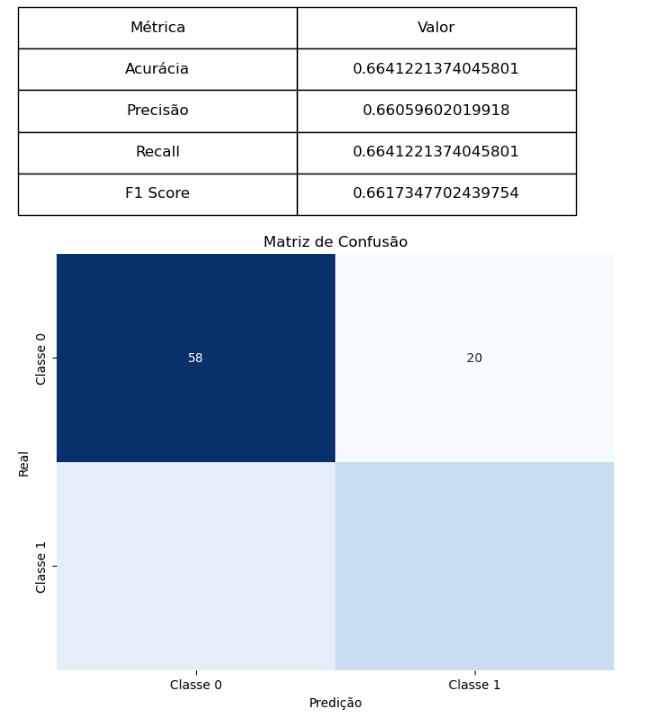